# Aprendizaje Automático Aplicado

#### Caso 2
#### Alumna: Lidia Cerdán Orts

In [1]:
%pylab
%matplotlib inline
import pandas as pd

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Ejercicio 1:

En el archivo "diagnosis.csv" Los datos han sido creados por un experto médico para poner a prueba un modelo que permite predecir dos enfermedades del sistema urinario. Los datos son:
* id: identificado del registro
* a1: temperatura del paciente
* a2: ocurrencia de nauseas
* a3: dolor lumbar
* a4: necesidad continua de orinar
* a5: dolores miccionales
* a6: ardor de la uretra, picazón o hinchazón de la salida de la uretra

Las enfermedades que se desean evaluar son:
* d1: inflamación de la vejiga urinaria
* d2: nefritis de origen en la pelvis renal

Crear un modelo que permite predecir cada una de las enfermedades con los datos suministrados. Evaluar el rendimiento de los modelos.

In [2]:
# importar los datos
diagnosis = pd.read_csv('diagnosis.csv', sep=';')
diagnosis.head(5)

,id,a1,a2,a3,a4,a5,a6,d1,d2
0,1,35.5,0,1,0,0,0,0,0
1,2,35.9,0,0,1,1,1,1,0
2,3,35.9,0,1,0,0,0,0,0
3,4,36.0,0,0,1,1,1,1,0
4,5,36.0,0,1,0,0,0,0,0


Observamos si existe la presencia de valores nulos:

In [3]:
# valores nulos
total = diagnosis.isnull().sum().sort_values(ascending=False)
total

d2    0
d1    0
a6    0
a5    0
a4    0
a3    0
a2    0
a1    0
id    0
dtype: int64

Seguidamente, veamos cuanta correlación hay entre las variables:

In [4]:
# correlaciones
correlacion = diagnosis.corr()
print(correlacion['d1'])
print(correlacion['d2'])

id   -0.243251
a1   -0.236718
a2    0.184630
a3   -0.521251
a4    0.695418
a5    0.666574
a6    0.149331
d1    1.000000
d2   -0.188777
Name: d1, dtype: float64
id    0.713408
a1    0.737055
a2    0.667947
a3    0.714286
a4    0.239046
a5    0.149331
a6    0.314286
d1   -0.188777
d2    1.000000
Name: d2, dtype: float64


Obviando el 'id', para la enfermedad 'd1' se observa que existe una correlación positiva fuerte con las variables 'a4' y 'a5' y una correlación negativa débil con la variable 'a3.

Para la enfermedad 'd2', 'a1','a2' y 'a3'son variables altamente correladas con la variable 'd2'. 

Posteriormente, cuando estudiemos cada caso se verá que son las que más capacidad predictiva tienen en el modelo.

#### Modelo para la enfermedad d1

In [5]:
# separación entre variables explicativas y la variable target
target = 'd1'
features = list(diagnosis.columns)
features.remove('d1')

# eliminación de identificadores
features.remove('id')

Haremos un análisis de las variables discretas y continuas con respecto a la variable target.

In [6]:
# Análisis de variables discretas: tabla de frecuencias
for var in ['a2', 'a3', 'a4', 'a5', 'a6','d2']:
    print("Tabla de frecuencias para:", var)
    print(pd.crosstab(diagnosis[target], diagnosis[var]))
    print()

Tabla de frecuencias para: a2
a2   0   1
d1        
0   51  10
1   40  19

Tabla de frecuencias para: a3
a3   0   1
d1        
0   10  51
1   40  19

Tabla de frecuencias para: a4
a4   0   1
d1        
0   40  21
1    0  59

Tabla de frecuencias para: a5
a5   0   1
d1        
0   51  10
1   10  49

Tabla de frecuencias para: a6
a6   0   1
d1        
0   40  21
1   30  29

Tabla de frecuencias para: d2
d2   0   1
d1        
0   30  31
1   40  19



Observaciones:
* Se destaca que para el síntoma a4, si no tiene dicho síntoma, no tiene la enfermedad.
* Para los síntomas a2 y a3, es muy probable que tenga la enfermedad sin aparecer los síntomas.
* Sólo 19/120 tenían ambas enfermedades a la vez y eran más aquellos que padecían la enfermedad d1.

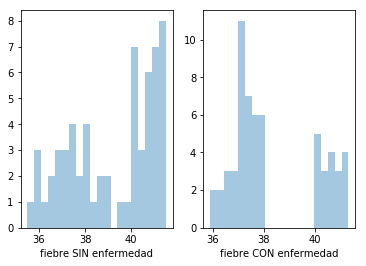

In [7]:
# Análisis de variables cuantitativas: histograma
# variable: temperatura del paciente
import seaborn as sns

fig, axs = plt.subplots(1,2)
sns.distplot(diagnosis['a1'][diagnosis['d1']==0], kde=False, ax=axs[0],bins=20,axlabel = "fiebre SIN enfermedad")
sns.distplot(diagnosis['a1'][diagnosis['d1']==1],kde=False ,ax=axs[1],bins=20, axlabel = "fiebre CON enfermedad")


Al comparar los histogramas observamos que cuando se tiene la enfermedad la temperatura corporal es mucho más baja.
Esto se puede utilizar para realizar una categorización de las variables.

Separaremos la fiebre en los siguientes intervalos: [36-37],[37-38.2],[38.2,39.9] y [39.9,42].

El procedimiento es reemplazar la variable a1 por la variable a1 segmentada en cuatro intervalos. Así, podremos hacer un mejor entrenamiento y una mejor predicción.

In [8]:
# división en 4 de la variable a1
diagnosis.loc[:, 'a1_grp'] = diagnosis['a1'].map(lambda x: 'n0' if x < 37 else 'n1' if x < 38.2 else 'n2' if x < 39.9 else 'n3' if x < 42 else 'n4')


In [9]:
# Transformación de la variable a1

# Eliminamos a1 y la reemplazamos por la que hemos creado
features.remove('a1')
features.append('a1_grp')

# # Listado de variables disponibles para hacer un modelo.
for var in features:
    print(var)

a2
a3
a4
a5
a6
d2
a1_grp


#### Creación de un modelo

Una vez transformadas las variables se puede proceder a la creación de un modelo. Para ello primero se han de crear las variables dummies, eliminar las variables colineales y separar los datos en una muestra de entrenamiento y otra de validación.

In [10]:
# Creación de variables dummies
data_model = pd.concat((pd.get_dummies(diagnosis['a1_grp'], prefix = 'a1'),
                        pd.get_dummies(diagnosis['a2'], prefix = 'a2'),
                        pd.get_dummies(diagnosis['a3'], prefix = 'a3'),
                        pd.get_dummies(diagnosis['a4'], prefix = 'a4'),
                        pd.get_dummies(diagnosis['a5'], prefix = 'a5'),
                        pd.get_dummies(diagnosis['a6'], prefix = 'a6'),
                        pd.get_dummies(diagnosis['d2'], prefix = 'd2')), axis = 1)

Veamos ahora si eliminamos alguna variable. Para ello, estudiaremos el coeficiente VIF.
El factor de inflación de la varianza (variance inflation factor, VIF) cuantifica la multicolinealidad en un análisis de regresión. Proporciona un índice que mide cuánto se incrementa la varianza de un coeficiente de regresión estimado debido a la colinealidad. 
Aquellas variables que sobrepasen el valor 5 serán eliminadas.

In [11]:
# Utilizamos el programa implementado 
from sklearn.linear_model import LinearRegression
def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

model_vars = selectDataUsingVIF(data_model)
calculateVIF(model_vars)

C:\Users\lidia\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


,a1_n1,a1_n2,a1_n3,a3_1,a4_1,a5_1,a6_1
VIF,2.398578,1.59016,2.279761,1.4493,2.184235,1.338548,1.886937


Se han seleccionado aquellas variables con mayor capacidad predictiva y ninguna de ellas tiene un VIF mayor que 5.

Una vez seleccionadas nuestras variables, lo que haremos será hacer el procedimiento de separar el conjunto test y de entrenamiento y encontrar un modelo que mejor ajuste nuestras predicciones.

In [12]:
from sklearn.cross_validation import train_test_split


# separación train-test
x_train, x_test, y_train, y_test = train_test_split(model_vars, diagnosis['d1'])

# validación del modelo
def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print('La matriz de confusión es')
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)


C:\Users\lidia\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Utilizaremos el modelo de Regresión Logística pues tiene una precisión muy alta:

La matriz de confusión es
[[46  0]
 [ 0 44]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


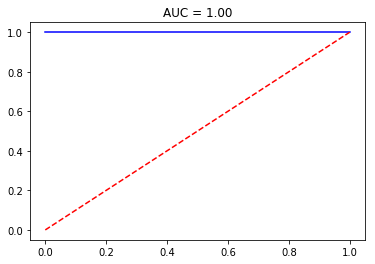

In [13]:
from sklearn.linear_model.logistic import LogisticRegression


model = LogisticRegression().fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# train
metricas_modelos(y_train, y_pred_train)

La matriz de confusión es
[[15  0]
 [ 0 15]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


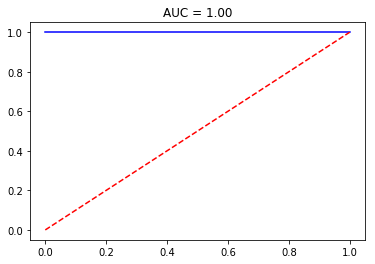

In [14]:
# test
metricas_modelos(y_test, y_pred_test)

Hagamos ahora una predicción, sabiendo que las variables se disponen de la siguiente manera:

In [15]:
x_train.head()

,a1_n1,a1_n2,a1_n3,a3_1,a4_1,a5_1,a6_1
29,1,0,0,0,1,1,1
59,1,0,0,0,1,0,0
96,0,0,1,1,1,0,1
73,0,0,1,0,0,0,0
17,0,0,0,0,1,1,1


Tomamos un paciente con fiebre entre 38 y 39, y con todos los síntomas:

In [16]:
nueva_pred = [0,0,1,1,1,1,1]
print(model.predict([nueva_pred]))


[1]


Nos devuelve '1' que nos indica que ese paciente padece la enfermedad.

#### Modelo para la enfermedad d2

Se procederá de manera análoga al modelo para la enfermedad d1.

In [17]:
# separación entre variables explicativas y la variable target
target = 'd2'
features = list(diagnosis.columns)
features.remove('d2')

# eliminación de identificadores
features.remove('id')

In [18]:
# Análisis de variables discretas: tabla de frecuencias
for var in ['a2', 'a3', 'a4', 'a5', 'a6','d1']:
    print("Tabla de frecuencias para:", var)
    print(pd.crosstab(diagnosis[target], diagnosis[var]))
    print()

Tabla de frecuencias para: a2
a2   0   1
d2        
0   70   0
1   21  29

Tabla de frecuencias para: a3
a3   0   1
d2        
0   50  20
1    0  50

Tabla de frecuencias para: a4
a4   0   1
d2        
0   30  40
1   10  40

Tabla de frecuencias para: a5
a5   0   1
d2        
0   40  30
1   21  29

Tabla de frecuencias para: a6
a6   0   1
d2        
0   50  20
1   20  30

Tabla de frecuencias para: d1
d1   0   1
d2        
0   30  40
1   31  19



Conclusiones:
* Para el síntoma a2, no hay personas que  tengan el síntoma y no tengan la enfermedad.
* Para el síntoma a3, si no tiene el síntoma no tiene la enfermedad.

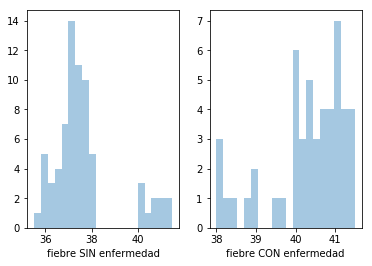

In [19]:
# Análisis de variables cuantitativas: histograma
# variable: temperatura del paciente
import seaborn as sns

fig, axs = plt.subplots(1,2)
sns.distplot(diagnosis['a1'][diagnosis['d2']==0], kde=False, ax=axs[0],bins=20,axlabel = "fiebre SIN enfermedad")
sns.distplot(diagnosis['a1'][diagnosis['d2']==1],kde=False ,ax=axs[1],bins=20, axlabel = "fiebre CON enfermedad")


De manera análoga, haremos una segmentación de intervalos con la fiebre puesto que se observa que no hay pacientes con fiebre entre 38 y 40 que tengan la enfermedad.

En este caso, también haremos cuatro intervalos:

In [25]:
diagnosis.loc[:, 'a1_grp_2'] = diagnosis['a1'].map(lambda x: 'n0' if x < 38 else 'n1' if x < 38.5 else 'n2'if x < 40 else 'n3')

In [26]:
features

['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'd1', 'a1_grp']

In [39]:
diagnosis = diagnosis.drop('a1_grp', 1)
diagnosis.columns

Index(['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'd1', 'd2', 'a1_grp_2'], dtype='object')

In [27]:
# Transformación de la variable a1

# Eliminamos a1 y la reemplazamos por la que hemos creado
features.remove('a1_grp')
features.append('a1_grp_2')

# # Listado de variables disponibles para hacer un modelo.
for var in features:
    print(var)

a1
a2
a3
a4
a5
a6
d1
a1_grp_2


In [40]:
# Creación de variables dummies
data_model = pd.concat((pd.get_dummies(diagnosis['a1_grp_2'], prefix = 'a1'),
                        pd.get_dummies(diagnosis['a2'], prefix = 'a2'),
                        pd.get_dummies(diagnosis['a3'], prefix = 'a3'),
                        pd.get_dummies(diagnosis['a4'], prefix = 'a4'),
                        pd.get_dummies(diagnosis['a5'], prefix = 'a5'),
                        pd.get_dummies(diagnosis['a6'], prefix = 'a6'),
                        pd.get_dummies(diagnosis['d1'], prefix = 'd1')), axis = 1)

In [41]:
model_vars = selectDataUsingVIF(data_model)
calculateVIF(model_vars)

C:\Users\lidia\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


,a1_n1,a1_n2,a1_n3,a3_1,a4_1,a5_1,a6_1
VIF,1.27651,1.406752,1.40821,1.533079,1.962421,1.37592,1.747938


In [43]:
# separación train-test
x_train, x_test, y_train, y_test = train_test_split(model_vars, diagnosis['d2'])


La matriz de confusión es
[[50  0]
 [ 0 40]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


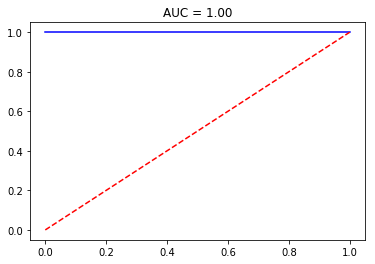

In [44]:
from sklearn.linear_model.logistic import LogisticRegression


model = LogisticRegression().fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# train
metricas_modelos(y_train, y_pred_train)

La matriz de confusión es
[[20  0]
 [ 0 10]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


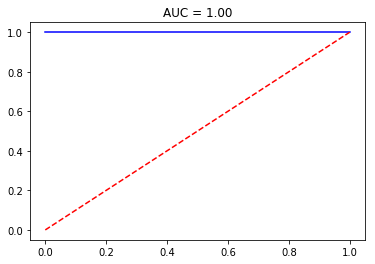

In [46]:
metricas_modelos(y_test, y_pred_test)

In [50]:
nueva_pred = [0,1,0,0,1,1,0]
print(model.predict([nueva_pred]))

[0]


# Ejercicio 2

In [51]:
from sklearn.decomposition import PCA

En el archivo “concrete.csv” se encuentra los datos de diferentes mezclas de hormigón. Utilizar el análisis de componentes principales y obtener el número de componentes principales con los que se puede explicar el 50%, 75% y 90% de la varianza. Obtener el porcentaje de la varianza que explica la primera componente principal.

In [52]:
# Leemos los datos
concrete = pd.read_csv('concrete.csv')
concrete.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [53]:
from sklearn.decomposition import PCA
pca      = PCA(n_components = None)
concrete_pca = pca.fit_transform(concrete)
for i in range(shape(concrete_pca)[1]):
    print("Varianza explicada con", i + 1, "componentes:", pca.explained_variance_ratio_[range(i + 1)].sum())

Varianza explicada con 1 componentes: 0.3249129815446272
Varianza explicada con 2 componentes: 0.5724331282512514
Varianza explicada con 3 componentes: 0.7560051466630762
Varianza explicada con 4 componentes: 0.8630074198158685
Varianza explicada con 5 componentes: 0.9634424828254187
Varianza explicada con 6 componentes: 0.9953882736798664
Varianza explicada con 7 componentes: 0.997959553582989
Varianza explicada con 8 componentes: 0.9997163809073328
Varianza explicada con 9 componentes: 0.9999999999999999


In [54]:
# tomando 3 componentes, veamos cuánto explica cada componente:
pca = PCA(n_components=3).fit(concrete)

for i in range(len(pca.explained_variance_)):
    print('La componente', i + 1, 'explica un porcentaje de varianza de', pca.explained_variance_ratio_[i] / sum(pca.explained_variance_ratio_),
          'y  es:', pca.components_[i])

print('====================================')
print('vectores asociados a las componentes principales')
for length, vector in zip(pca.explained_variance_ratio_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    print(v)

La componente 1 explica un porcentaje de varianza de 0.42977615030632704 y  es: [ 0.90443974 -0.25467084 -0.23937562  0.00542035 -0.00112053 -0.01281057
 -0.21226345  0.10031213  0.06721449]
La componente 2 explica un porcentaje de varianza de 0.3274053725680982 y  es: [ 0.02306241  0.78881234 -0.29906341  0.07548306 -0.00487303 -0.27609068
 -0.44648591  0.07000456  0.04008098]
La componente 3 explica un porcentaje de varianza de 0.24281847712557478 y  es: [ 0.15204486  0.07144972 -0.04889159 -0.04206219  0.02418344 -0.75985985
  0.61268308 -0.11771877  0.02018896]
vectores asociados a las componentes principales
[ 1.54662286 -0.43549583 -0.40934049  0.00926898 -0.00191614 -0.02190651
 -0.36297775  0.17153718  0.11493908]
[ 0.03442161  1.17733547 -0.44636467  0.11266163 -0.0072732  -0.41207691
 -0.66639893  0.10448475  0.05982254]
[ 0.19543225  0.09183855 -0.06284325 -0.05406502  0.03108441 -0.97669282
  0.7875178  -0.1513109   0.02595006]


Respuesta a las preguntas:
1. Obtener el número de componentes principales con los que se puede explicar el 50%, 75% y 90% de la varianza:
    * Con $n=2$ explicamos el $57%$ de la varianza
    * Con $n=3$ explicamos el $75%$ de la varianza
    * Con $n=5$ explicamos el $96%$ de la varianza
    
2. Obtener el porcentaje de varianza que explica la primera componente
    * Si seleccionamos 9 componentes principales, la primera componente explica el $32%$ de la varianza
    * Si seleccionamos 3 componentes principales (total un $75%$ de la varianza) la primera componente de ese 75% explica un $42%.

# Ejercicio 3

Crear un conjunto de datos utilizando el siguiente código:

trX = np.linspace(-1, 1, 101)

trY = np.linspace(-1, 1, 101)

for i in range(len(trY)):

    trY[i] = math.sin(0.2 * trX[i]) + math.exp(-0.7 * trX[i]) + np.random.randn() * 0.033

Ahora utilizar Theano para obtener los parámetros $w_0$ y $w_1$ del modelo correspondiente.

  $y = sin(w_0 * x) + exp(w_1 * x)$

In [63]:
import theano
import theano.tensor as T
import math

In [65]:
trX = np.linspace(-1, 1, 101)

trY = np.linspace(-1, 1, 101)

for i in range(len(trY)):

    trY[i] = math.sin(0.2 * trX[i]) + math.exp(-0.7 * trX[i]) + np.random.randn() * 0.033

X = T.scalar()
Y = T.scalar()

def model(x_1,w_0,w_1):
    return (T.sin(w_0 * x_1) + T.exp(w_1 * x_1))


w_0 = theano.shared(np.asarray(0., dtype = theano.config.floatX))
w_1 = theano.shared(np.asarray(0., dtype = theano.config.floatX))
y = model(X, w_0, w_1)

cost     = T.mean(T.sqr(y - Y))
gradient_w_0 = T.grad(cost = cost, wrt = w_0)
gradient_w_1 = T.grad(cost = cost, wrt = w_1)
updates  = [[w_0, w_0 - gradient_w_0 * 0.01], [w_1, w_1 - gradient_w_1 * 0.01]]

train = theano.function(inputs = [X, Y],
                        outputs = cost,
                        updates = updates,
                        allow_input_downcast = True)

for i in range(15):
    for x, y in zip(trX, trY):
        cost_i = train(x, y)
    print('En el paso', i, 'el valor de w_0 es', w_0.get_value(), 'y w_1 es', w_1.get_value(), 'con un coste', cost_i) 

En el paso 0 el valor de w_0 es -0.17228826025869748 y w_1 es -0.18514024803518223 con un coste 0.01663392121732371
En el paso 1 el valor de w_0 es -0.20825257318723017 y w_1 es -0.2471996889290006 con un coste 0.04699678822554307
En el paso 2 el valor de w_0 es -0.20825356863552202 y w_1 es -0.2732149569388029 con un coste 0.05632966850929366
En el paso 3 el valor de w_0 es -0.19886901196447976 y w_1 es -0.2898427855818305 con un coste 0.057949570463224964
En el paso 4 el valor de w_0 es -0.18693399962187301 y w_1 es -0.304259856700432 con un coste 0.057426820246291276
En el paso 5 el valor de w_0 es -0.17419778981674053 y w_1 es -0.31829217422587536 con un coste 0.056296315173846645
En el paso 6 el valor de w_0 es -0.16112140638225841 y w_1 es -0.3323736518938441 con un coste 0.054949693582601905
En el paso 7 el valor de w_0 es -0.14784487333729626 y w_1 es -0.3465815138923827 con un coste 0.05348726487336894
En el paso 8 el valor de w_0 es -0.13443069354975726 y w_1 es -0.3609007856